## How to use the t-SNE algorithm on APOGEE globular cluster data. 
##### Steffani Grondin (September 23, 2022)

#### STEP 0: Import the necessary packages/algorithms.

In [1]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from collections import Counter

# Specific t-SNE/visualization packages:
from sklearn.manifold import TSNE
from shapely.geometry import Point, Polygon

######
from sklearn.cluster import DBSCAN as dbscan
from collections import Counter
from scipy.spatial import ConvexHull, distance_matrix
from tqdm import tqdm


#### STEP 1: Load in the M3 datafile. 

This example uses APOGEE DR17 data (https://www.sdss.org/dr17/) with astroNN chemical abundances (https://astronn.readthedocs.io/en/latest/) and includes all stars that are within a 10x10 degree field of view around M3's centre.

In [7]:
M3 = pd.read_csv('../../data/M3data_10x10.csv', delimiter=',')

# Spatial:
ra = M3["ra"]   #APOGEE
dec = M3["dec"]   #APOGEE

# Identification:
apogee_ID = M3["apogee_ID"]   #APOGEE
gaia_ID = M3["gaia_ID"]  # Gaia

# Kinematic:
parallax = M3["parallax"]  # Gaia
pmra = M3["pmra"]  # Gaia
pmra_err = M3["pmra_err"]  # Gaia
pmdec = M3["pmdec"]  # Gaia
pmdec_err = M3["pmdec_err"]  # Gaia
RV = M3["RV"]   #APOGEE
RV_err = M3["RV_err"]   #APOGEE
dist = M3["dist"]   #APOGEE
dist_err = M3["dist_err"]   #APOGEE
jr = M3["jr"]   #APOGEE
jr_err = M3["jr_err"]   #APOGEE
jz = M3["jz"]   #APOGEE
jz_err = M3["jz_err"]   #APOGEE
jphi = M3["jphi"]   #APOGEE
jphi_err = M3["jphi_err"]    #APOGEE

# Spectral (useful for filtering):
TEFF_ERR = M3["TEFF_err"]   #APOGEE
TEFF = M3["TEFF"]   #APOGEE
LOGG_ERR = M3["LOGG_err"]   #APOGEE
LOGG = M3["LOGG"]   #APOGEE
SNR = M3["SNR"]   #APOGEE

# Chemical abundances from astroNN:
FE_H = M3['FEH'] 
C_FE = M3['CFE']
CI_FE = M3['CIFE']
N_FE = M3['NFE']
O_FE = M3['OFE']
MG_FE = M3['MGFE']
AL_FE = M3['ALFE']
SI_FE = M3['SIFE']
P_FE = M3['PFE']
S_FE = M3['SFE']
K_FE = M3['KFE']
CA_FE = M3['CAFE']
TI_FE = M3['TIFE']
TIII_FE = M3['TIIIFE']
V_FE = M3['VFE']
CR_FE = M3['CRFE']
MN_FE = M3['MNFE']
CO_FE = M3['COFE']
NI_FE = M3['NIFE']

# Chemical abundance errors from astroNN:
FE_H_err = M3["FEH_err"] 
C_FE_err = M3['CFE_err']
CI_FE_err = M3['CIFE_err']
N_FE_err = M3['NFE_err']
O_FE_err = M3['OFE_err']
MG_FE_err = M3['MGFE_err']
AL_FE_err = M3['ALFE_err']
SI_FE_err = M3['SIFE_err']
P_FE_err = M3['PFE_err']
S_FE_err = M3['SFE_err']
K_FE_err = M3['KFE_err']
CA_FE_err = M3['CAFE_err']
TI_FE_err = M3['TIFE_err']
TIII_FE_err = M3['TIIIFE_err']
V_FE_err = M3['VFE_err']
CR_FE_err = M3['CRFE_err']
MN_FE_err = M3['MNFE_err']
CO_FE_err = M3['COFE_err']
NI_FE_err = M3['NIFE_err']

# Number of stars in the initial sample of APOGEE DR16: 
print("There are {} stars in our initial sample".format(len(ra)))

cols = [ra, dec, apogee_ID, gaia_ID, parallax, pmra, pmra_err, pmdec, pmdec_err, RV, RV_err, dist, dist_err,
        jr, jr_err, jphi, jphi_err, jz, jz_err, TEFF, TEFF_ERR, LOGG, LOGG_ERR, SNR, FE_H, FE_H_err, C_FE, 
        C_FE_err, CI_FE, CI_FE_err, N_FE, N_FE_err, O_FE, O_FE_err, MG_FE, MG_FE_err, AL_FE, AL_FE_err, SI_FE,
        SI_FE_err, P_FE, P_FE_err, S_FE, S_FE_err, K_FE, K_FE_err, CA_FE, CA_FE_err, TI_FE, TI_FE_err, TIII_FE,
        TIII_FE_err, V_FE, V_FE_err, CR_FE, CR_FE_err, MN_FE, MN_FE_err, CO_FE, CO_FE_err, NI_FE, NI_FE_err]

There are 5289 stars in our initial sample


#### STEP 2: Filter the data. 

First, we remove all stars without proper motions and chemical abundances for all 19 elements. Next, for stars with multiple spectra, we select the one with the highest SNR to represent the source. Finally, we remove all stars with low signal-to-noise (SNR) ratios. 

In [21]:
print("There are {} stars in our initial sample".format(len(ra)))

### Filter 1: Remove stars that do not have proper motion values. ###
pm_filter_nan = np.isnan(pmra)
pm_filter = np.where(pm_filter_nan==False)
data_pmfilter = []
for i in cols:
    x = np.array(i)[pm_filter]
    data_pmfilter.append(x)
print("There are {} stars in our sample after the proper motion filtering.".format(len(data_pmfilter[0])))

### Filter 2: Remove stars that do not have data for all 19 abundances. ###
abundance_filter = np.where((data_pmfilter[24] > -9999) & (data_pmfilter[26] > -9999) & (data_pmfilter[28]  > -9999)
                            & (data_pmfilter[30]  > -9999) & (data_pmfilter[32]  > -9999) & (data_pmfilter[34]  > -9999)
                            & (data_pmfilter[36]  > -9999) & (data_pmfilter[38]  > -9999) & (data_pmfilter[40]  > -9999)
                            & (data_pmfilter[42]  > -9999) & (data_pmfilter[44]  > -9999) & (data_pmfilter[46]  > -9999)
                            & (data_pmfilter[48]  > -9999) & (data_pmfilter[50]  > -9999) & (data_pmfilter[52]  > -9999)
                            & (data_pmfilter[54]  > -9999) & (data_pmfilter[56]  > -9999) & (data_pmfilter[58]  > -9999)
                            & (data_pmfilter[60]  > -9999))

data_abundancefilter = []
for i in data_pmfilter:
    y = np.array(i)[abundance_filter]
    data_abundancefilter.append(y)
print("There are {} stars in our sample after the abundance filtering.".format(len(data_abundancefilter[0])))

### Filter 3: Remove all duplicate spectra (i.e. select spectra with highest SNR for multiple measurements). ###
d =  Counter(data_abundancefilter[0])
duplicates = [k for k, v in d.items() if v > 1]
a_list = np.array(range(0, len(duplicates)))
max_SNR_array = []

for i in a_list:
    indices = np.where(data_abundancefilter[0] == duplicates[i])
    snr_val = data_abundancefilter[23][indices]
    maximum = max(snr_val)
    index_maximum = np.where((data_abundancefilter[0] == duplicates[i]) & (data_abundancefilter[23] == maximum))
    index_maximum = int(index_maximum[0])
    max_SNR_array.append(index_maximum)

idx_sort = np.argsort(data_abundancefilter[0])
sorted_ra_array = data_abundancefilter[0][idx_sort]
vals, idx_start, count = np.unique(sorted_ra_array, return_counts=True, return_index=True)
res = np.split(idx_sort, idx_start[1:])
vals = vals[count == 1]
listtest =  np.array(range(0, len(vals)))

unique_array = []
for i in listtest:
    unique_val = np.where(vals[i] == data_abundancefilter[0])
    unique_val = int(unique_val[0])
    unique_array.append(unique_val)
    
#print("There are {} stars that do not have duplicate spectra.".format(len(unique_array)))
#print("There are {} stars that have multiple spectra, in which we select highest SNR.".format(len(max_SNR_array)))

duplicates_filter = np.concatenate((unique_array, max_SNR_array))
sortedarray = np.sort(duplicates_filter)

data_duplicatesfilter = []
for i in data_abundancefilter:
    z = np.array(i)[duplicates_filter]
    data_duplicatesfilter.append(z)

print("There are {} stars in our sample after removing sources with duplicate spectra.".format(len(data_duplicatesfilter[0])))

### Filter 4: Remove all stars with low SNR. ###
SNR_filter = np.where(data_duplicatesfilter[23] > 50)
data_snrfilter = []
for i in data_duplicatesfilter:
    a = np.array(i)[SNR_filter]
    data_snrfilter.append(a)

print("There are {} stars in our sample after removing sources with low SNR.".format(len(data_snrfilter[0])))

print()
print("The final amount of stars in our sample is:{}".format(len(data_snrfilter[0])))
print("There are {} stars in our M3 control group.".format(len(ra_control)))

There are 5289 stars in our initial sample
There are 5240 stars in our sample after the proper motion filtering.
There are 5053 stars in our sample after the abundance filtering.
There are 3309 stars in our sample after removing sources with duplicate spectra.
There are 3212 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is:3212
There are 133 stars in our M3 control group.


#### ***CHECK-IN: Now that your data has been reduced, do some exploratory data analysis to see what the sample looks like!*

What parameters are in this file? What parameters might be useful to connect extra-tidal stars with a suspected birth cluster?

#### STEP 3: Define parameters for your GC of interest. 

These parameters are taken from the Baumgardt & Hilker (2018) catalogue: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/.

In [22]:
ra_M3 = 205.548  # [deg]
dec_M3 = 28.3772  # [deg]
dist_M3 = 10180  # [pc]
rt_M3 = 159.0339  # [pc] -- tidal radius @ apogalacticon
rhm_M3 = 6.34  # [pc]
rhm_M3_deg = math.degrees(math.atan(rhm_M3 / dist_M3))  # deg
pmra_M3 = -0.152  # [mas/yr]
pmdec_M3 = -2.670  # [mas/yr]

#### STEP 4: Define a control group of cluster members.

We must define a control group of likely cluster members of M3 so we can see where these stars end up in the t-SNE projection. 

In [23]:
# Select all the stars within some radius of the cluster:
def in_circle(center_x, center_y, radius, x, y):
    square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
    return square_dist <= (radius) ** 2

ra_filtered = data_snrfilter[0]
dec_filtered = data_snrfilter[1]

# Select stars within 8 * r,hm (useful for large enough sample of probable cluster members):
in_halfmass = in_circle(ra_M3, dec_M3, 8*rhm_M3_deg, ra_filtered, dec_filtered)
indices_control = np.where(in_halfmass==True)

controlgroup = []
for i in data_snrfilter:
    b = np.array(i)[indices_control]
    controlgroup.append(b)

# Example control group parameters: 
ra_control = controlgroup[0]
dec_control = controlgroup[1]

print("There are {} stars in our M3 control group.".format(len(ra_control)))

There are 133 stars in our M3 control group.


#### ***CHECK-IN: Add this control group to your above exploratory plots.* 

What do you notice about these stars? What changes if you adjust the control group radius (i.e. what if you go larger or smaller than 8*r,hm)?


In [46]:
def count_matches(array1, array2):
    # Convert the arrays to sets
    set1 = set(array1)
    set2 = set(array2)

    # Find the intersection of the sets and return its length
    matches = len(set1.intersection(set2))

    return matches

def a_near_b(a_points, b_points, min_sep):

    # Calculate the distances between each point and each facet of the hull
    distances = distance_matrix(a_points, b_points)

    # Find the minimum distance from each point to the facets
    min_distances = distances.min(axis=1)
    
    # Check which points are inside the hull
    near_points = (min_distances < min_sep).tolist()
    
    indices = np.where(near_points)
    count = np.shape(np.where(near_points)[0])[0]
    return indices, count

#### STEP 5: Run t-SNE on the control group and full filtered sample of APOGEE DR17 stars.

First, we standardize the data to ensure that no elements dominate or skew the t-SNE run. We want to include 19 chemical abundances and radial velocities in our run.  

In [25]:
FE_H_filtered, C_FE_filtered, CI_FE_filtered = data_snrfilter[24], data_snrfilter[26], data_snrfilter[28]
N_FE_filtered, O_FE_filtered, MG_FE_filtered = data_snrfilter[30], data_snrfilter[32], data_snrfilter[34]
AL_FE_filtered, SI_FE_filtered, P_FE_filtered = data_snrfilter[36], data_snrfilter[38], data_snrfilter[40]
S_FE_filtered, K_FE_filtered, CA_FE_filtered = data_snrfilter[42], data_snrfilter[44], data_snrfilter[46]
TI_FE_filtered, TIII_FE_filtered, V_FE_filtered = data_snrfilter[48], data_snrfilter[50], data_snrfilter[52]
CR_FE_filtered, MN_FE_filtered, CO_FE_filtered, NI_FE_filtered = data_snrfilter[54], data_snrfilter[56], data_snrfilter[58], data_snrfilter[60]
RV_filtered  = data_snrfilter[9]

pretsne_array = np.array([FE_H_filtered, C_FE_filtered, CI_FE_filtered, N_FE_filtered, O_FE_filtered, MG_FE_filtered,
                      AL_FE_filtered, SI_FE_filtered, P_FE_filtered, S_FE_filtered, K_FE_filtered, CA_FE_filtered, 
                      TI_FE_filtered, TIII_FE_filtered, V_FE_filtered, CR_FE_filtered, MN_FE_filtered, CO_FE_filtered,
                       NI_FE_filtered, RV_filtered])

standardized_array = []
for i in pretsne_array:
    mean, sigma = np.mean(i), np.std(i)
    norm = (i - mean) / sigma
    standardized_array.append(norm)

Next, we apply the t-SNE algorithm via scikit-learn to reduce the dimensionality of the data from 20-D to 2-D.

In [96]:
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
tsne_init = TSNE(n_components=2)
tsne_2d = tsne_init.fit_transform(standardized_array_transpose)

# Get t-SNE outputs for complete filtered dataset:
t_SNE_dimX = tsne_2d[:, 0]
t_SNE_dimY = tsne_2d[:, 1]

# Get t-SNE outputs for control group:
tsne_dimX_control = t_SNE_dimX[indices_control]
tsne_dimY_control = t_SNE_dimY[indices_control]

########
tsne_XY = np.append(t_SNE_dimX, t_SNE_dimY).reshape(2,len(t_SNE_dimX)).T
tsne_XY_control = np.append(tsne_dimX_control, tsne_dimY_control).reshape(2,len(tsne_dimX_control)).T

#Get index of main control star grouping
# print(indices_control)
# print(np.shape(indices_control))

clustering_control = dbscan(eps=5, min_samples=5).fit(tsne_XY_control)    
control_labels = clustering_control.labels_ 
label_of_max_control_group = Counter(control_labels).most_common(1)[0][0]
index_of_controls_wrt_controls = np.where(control_labels == label_of_max_control_group)[0]

# print(index_of_controls_wrt_controls)
# print(np.shape(index_of_controls_wrt_controls))
index_of_controls_wrt_all_stars = indices_control[0][index_of_controls_wrt_controls]
# print(index_of_controls_wrt_all_stars)
# print(np.shape(index_of_controls_wrt_all_stars))

ref_points = tsne_XY_control[index_of_controls_wrt_controls]
star_indices_true, star_count_true = a_near_b(tsne_XY, ref_points,3.5)
print(star_count_true)

228


Finally, we plot the 2-D t-SNE projection. 

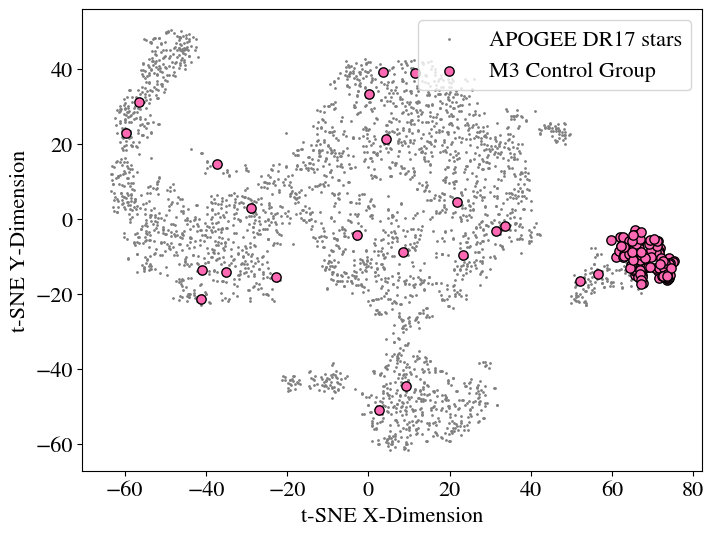

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(t_SNE_dimX, t_SNE_dimY, s=1, c='gray', label='APOGEE DR17 stars')
ax.scatter(tsne_dimX_control , tsne_dimY_control, s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
ax.set_xlabel("t-SNE X-Dimension", fontsize=16)
ax.set_ylabel("t-SNE Y-Dimension", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.legend(fontsize=16, loc=1)
plt.show()





  0%|          | 0/19 [00:00<?, ?it/s]

Cl_FE


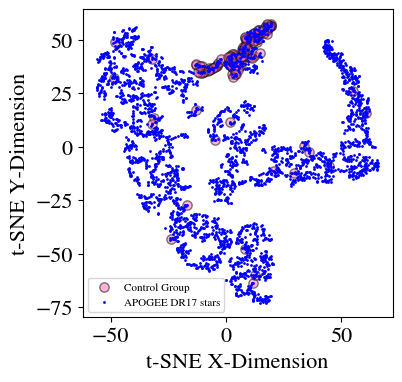





 16%|█▌        | 3/19 [00:21<01:52,  7.02s/it]

identified 212 ETs in common with result from all 19 abundances
misidentified 31 ETs not in result with all 19 abundances
N_FE


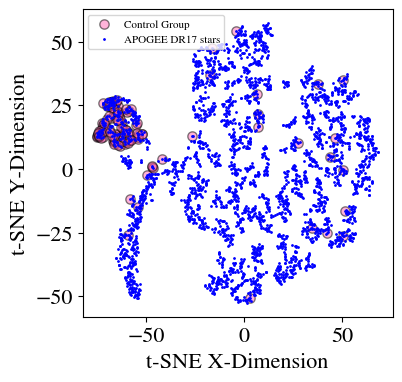





 21%|██        | 4/19 [00:45<03:01, 12.13s/it]

identified 210 ETs in common with result from all 19 abundances
misidentified 24 ETs not in result with all 19 abundances
O_FE


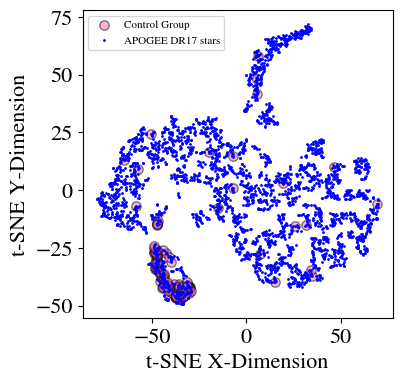





 26%|██▋       | 5/19 [01:06<03:27, 14.85s/it]

identified 201 ETs in common with result from all 19 abundances
misidentified 22 ETs not in result with all 19 abundances
MG_FE


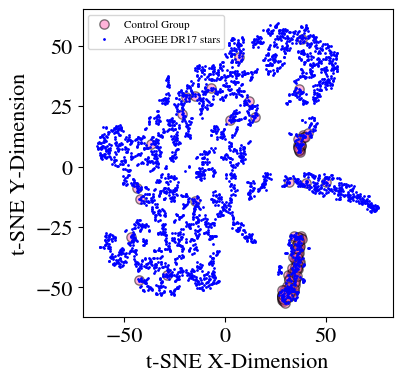





 32%|███▏      | 6/19 [01:30<03:49, 17.68s/it]

identified 180 ETs in common with result from all 19 abundances
misidentified 11 ETs not in result with all 19 abundances
AL_FE


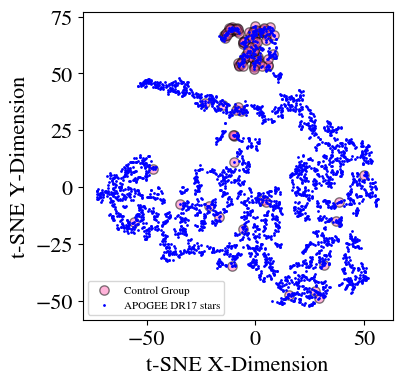





 37%|███▋      | 7/19 [01:59<04:13, 21.09s/it]

identified 210 ETs in common with result from all 19 abundances
misidentified 30 ETs not in result with all 19 abundances
SI_FE


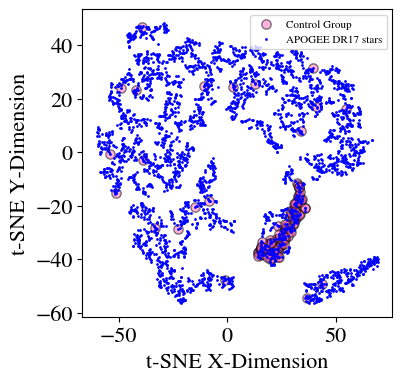





 42%|████▏     | 8/19 [02:34<04:36, 25.11s/it]

identified 206 ETs in common with result from all 19 abundances
misidentified 25 ETs not in result with all 19 abundances
P_FE


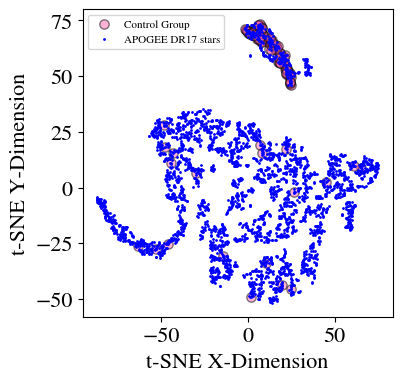





 47%|████▋     | 9/19 [03:06<04:32, 27.26s/it]

identified 213 ETs in common with result from all 19 abundances
misidentified 26 ETs not in result with all 19 abundances
S_FE


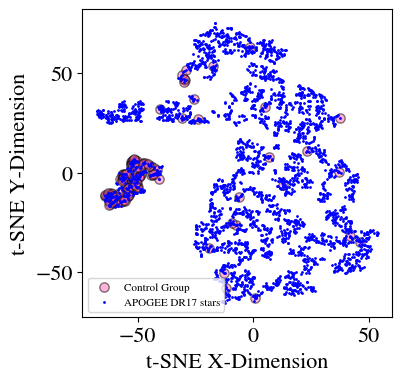





 53%|█████▎    | 10/19 [03:35<04:09, 27.70s/it]

identified 205 ETs in common with result from all 19 abundances
misidentified 24 ETs not in result with all 19 abundances
K_FE


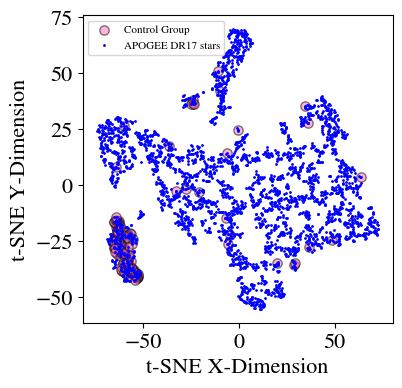





 58%|█████▊    | 11/19 [04:10<03:59, 29.98s/it]

identified 200 ETs in common with result from all 19 abundances
misidentified 23 ETs not in result with all 19 abundances
CA_FE


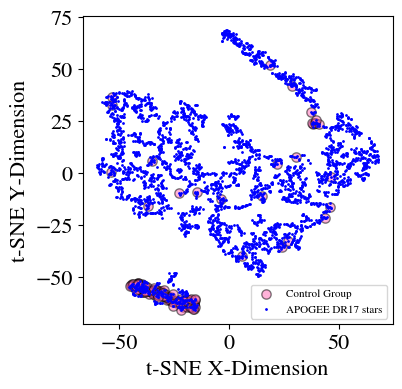





 63%|██████▎   | 12/19 [04:42<03:33, 30.52s/it]

identified 198 ETs in common with result from all 19 abundances
misidentified 17 ETs not in result with all 19 abundances
TI_FE


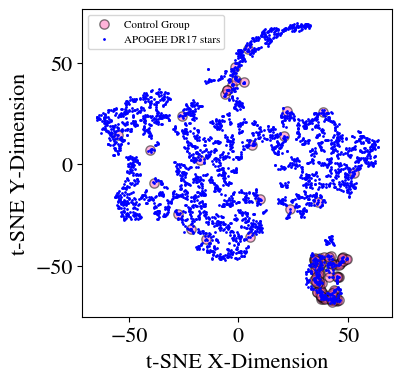





 68%|██████▊   | 13/19 [05:06<02:51, 28.51s/it]

identified 209 ETs in common with result from all 19 abundances
misidentified 25 ETs not in result with all 19 abundances
TIII_FE


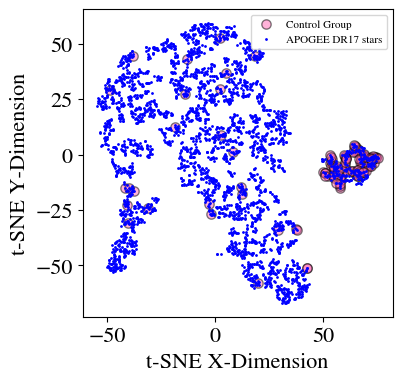





 74%|███████▎  | 14/19 [05:28<02:13, 26.79s/it]

identified 206 ETs in common with result from all 19 abundances
misidentified 27 ETs not in result with all 19 abundances
V_FE


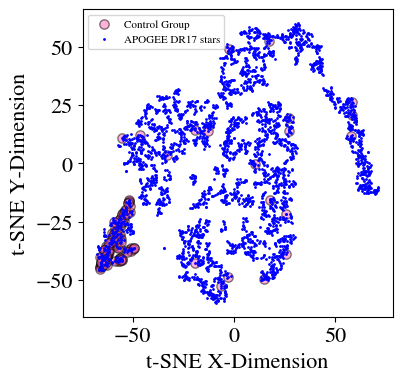





 79%|███████▉  | 15/19 [05:52<01:43, 25.98s/it]

identified 205 ETs in common with result from all 19 abundances
misidentified 23 ETs not in result with all 19 abundances
CR_FE


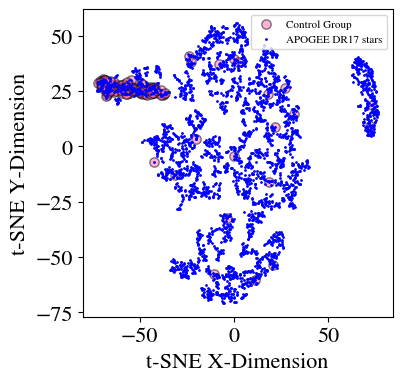





 84%|████████▍ | 16/19 [06:14<01:14, 24.73s/it]

identified 200 ETs in common with result from all 19 abundances
misidentified 26 ETs not in result with all 19 abundances
MN_FE


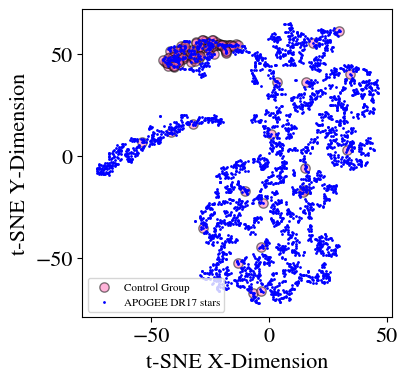





 89%|████████▉ | 17/19 [06:38<00:48, 24.32s/it]

identified 210 ETs in common with result from all 19 abundances
misidentified 35 ETs not in result with all 19 abundances
CO_FE


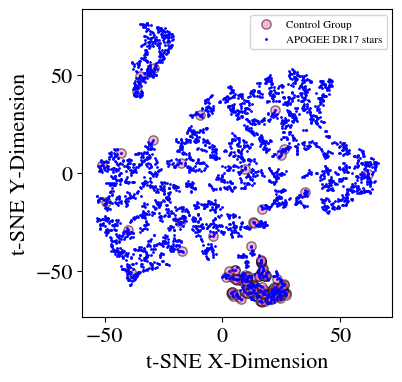





 95%|█████████▍| 18/19 [07:01<00:24, 24.20s/it]

identified 210 ETs in common with result from all 19 abundances
misidentified 27 ETs not in result with all 19 abundances
NI_FE


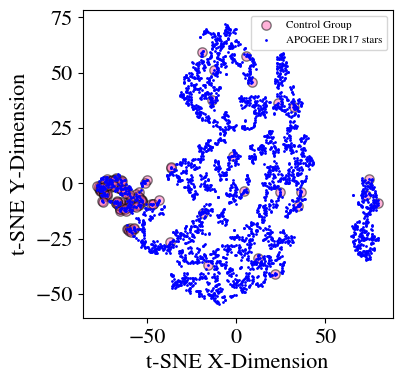





100%|██████████| 19/19 [07:25<00:00, 23.43s/it]

identified 228 ETs in common with result from all 19 abundances
misidentified 3 ETs not in result with all 19 abundances


In [97]:
abundance_labels= ['FE_H', 'C_FE',  'Cl_FE', 'N_FE', 'O_FE', 'MG_FE', 
                'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE', 
                'TI_FE', 'TIII_FE','V_FE', 'CR_FE', 'MN_FE', 'CO_FE','NI_FE']

all_array = np.array([FE_H_filtered, C_FE_filtered, CI_FE_filtered, N_FE_filtered, O_FE_filtered, MG_FE_filtered,
                          AL_FE_filtered, SI_FE_filtered, P_FE_filtered, S_FE_filtered, K_FE_filtered, CA_FE_filtered, 
                          TI_FE_filtered, TIII_FE_filtered, V_FE_filtered, CR_FE_filtered, MN_FE_filtered, CO_FE_filtered,
                           NI_FE_filtered])

n_cluster_stars_array=[]
matches_array=[]
misses_array=[]

for i in tqdm(range(0,len(all_array))):
    
    if i != 0 and i != 1:

        pretsne_array = np.array([all_array[0], all_array[1], all_array[i]])

        standardized_array = []
        mean=np.nanmean(pretsne_array,axis=1);sigma=np.nanstd(pretsne_array,axis=1)
        for j in range(len(mean)):
            standardized_array.append((pretsne_array[j]-mean[j])/sigma[j])

        standardized_array_transpose = np.transpose(standardized_array)

        # Run t-SNE on the transposed array:
        tsne_init = TSNE(n_components=2)
        tsne_2d = tsne_init.fit_transform(standardized_array_transpose)

        # Get t-SNE outputs for complete filtered dataset:
        t_SNE_dimX = tsne_2d[:, 0]
        t_SNE_dimY = tsne_2d[:, 1]
        tsne_XY = np.append(t_SNE_dimX, t_SNE_dimY).reshape(2,len(t_SNE_dimX)).T

        # Get t-SNE outputs for control group:
        tsne_dimX_control = t_SNE_dimX[indices_control]
        tsne_dimY_control = t_SNE_dimY[indices_control]
        tsne_XY_control = np.append(tsne_dimX_control, tsne_dimY_control).reshape(2,len(tsne_dimX_control)).T

        print(abundance_labels[i])
        fig, ax = plt.subplots(figsize=(4,4))
        ax.scatter(tsne_dimX_control , tsne_dimY_control, s=45, edgecolor='k', c='hotpink', label='Control Group',alpha=.5)
        ax.scatter(t_SNE_dimX, t_SNE_dimY, s=1, c='blue', label='APOGEE DR17 stars')
        ax.set_xlabel("t-SNE X-Dimension", fontsize=16)
        ax.set_ylabel("t-SNE Y-Dimension", fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.tick_params(axis='both', which='minor', labelsize=16)

        ax.legend(fontsize=8)
        plt.show()


        #Get index of main control star grouping
        clustering_control = dbscan(eps=5, min_samples=5).fit(tsne_XY_control)    
        control_labels = clustering_control.labels_ 
        label_of_max_control_group =  Counter(control_labels).most_common(1)[0][0]
        index_of_controls_wrt_controls = np.where(control_labels == label_of_max_control_group)
        index_of_controls_wrt_all_stars = indices_control[0][index_of_controls_wrt_controls]

        ref_points = tsne_XY_control[index_of_controls_wrt_controls]
        star_indices, star_count = a_near_b(tsne_XY, ref_points,4)

        correct_matches = count_matches(star_indices[0], star_indices_true[0])
        incorrect_matches = len(star_indices[0]) - correct_matches
        print('identified', correct_matches, 'ETs in common with result from all 19 abundances')
        print('misidentified', incorrect_matches, 'ETs not in result with all 19 abundances')

        n_cluster_stars_array.append(star_count)
        matches_array.append(correct_matches)
        misses_array.append(incorrect_matches)

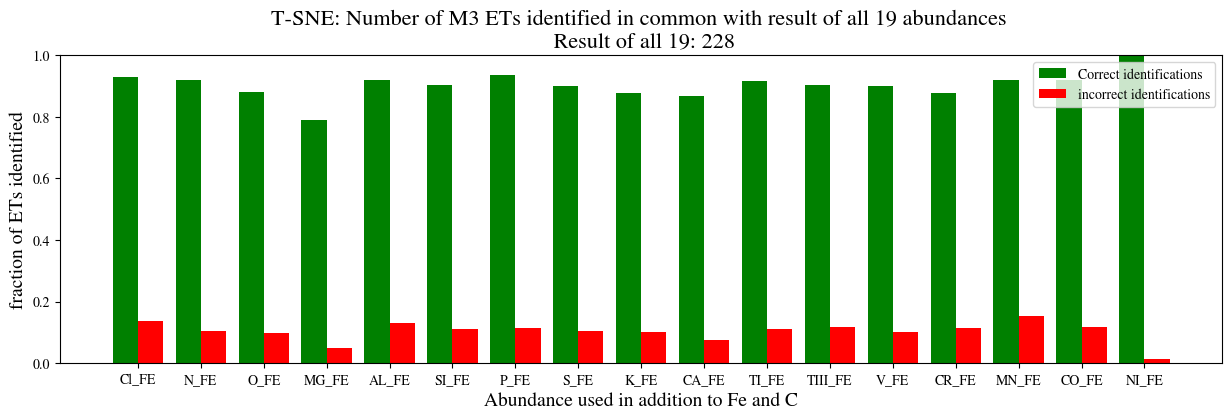

In [98]:
plt.figure(figsize=(15,4))

X_axis = np.arange(len(abundance_labels[2:]))

plt.bar(X_axis - 0.2, np.array(matches_array)/star_count_true, 0.4, label = 'Correct identifications', color='green')
plt.bar(X_axis + 0.2, np.array(misses_array)/star_count_true, 0.4, label = 'incorrect identifications',color='red')

plt.ylabel('fraction of ETs identified',fontsize=14)
plt.xlabel('Abundance used in addition to Fe and C',fontsize=14)
plt.title("T-SNE: Number of M3 ETs identified in common with result of all 19 abundances \n Result of all 19: {}".format(star_count_true), fontsize=16)
plt.ylim(0,1)
plt.xticks(X_axis, abundance_labels[2:])
plt.legend()
plt.show()



#### ***CHECK-IN: You succesfully ran t-SNE!*

What does this specific t-SNE projection actually tell you? How could you improve this t-SNE run? Importantly, how could you extend this method to find extra-tidal candidates of M3?

#### Improving the Dimensionality Reduction
Fine tune the hyper-parameters:
- understand how the different hyper-parameters affect the data
- what combination of hyper-parameters achieve the best separation of the control group? to acheive the best 

Helpful Papers:

https://distill.pub/2016/misread-tsne/ 

https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868 

Dimensional Reduction Astronomy Example:
https://arxiv.org/pdf/2210.02471.pdf
